In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 150
import datetime as dt
import numpy as np
from numpy.fft import fft, ifft

Loads data and cleans it a bit. Loads the milking data, removes some bad stuf and sums yield and count by day.

In [2]:
#Loads the milking data
milk = pd.read_csv("AllMilkings.csv", usecols=["FarmName_Pseudo", "SE_Number", "StartDate", "TotalYield"])
#Removes som bad stuff
milk = milk[milk["TotalYield"].notnull()]
milk = milk[milk["SE_Number"] != "Unknown"]
milk = milk.drop_duplicates()
#Sorts by date
milk = milk.sort_values(["StartDate"], ignore_index = True)

#Creating series for sum and count for daily milk events
milksum = milk.groupby(['SE_Number','StartDate'])["TotalYield"].sum()
milkcount = milk.groupby(['SE_Number','StartDate'])["TotalYield"].count()
#Remove old total yield
milk = milk.drop(labels=["TotalYield"], axis = 1)
#Drop "duplicates"
milk = milk.drop_duplicates()
#Setting multiindex and joining on multiindex
milk = milk.set_index(["SE_Number","StartDate"])
milk = milksum.to_frame().rename({"TotalYield": "DailyYield"}, axis = 1).join(milk)
#Resetting index
milk = milk.reset_index(level=[0])
milk = milk.sort_index()
milk.index = pd.to_datetime(milk.index)
milk["DailyYield"] = round(milk["DailyYield"], 2)

Imputing the data for every cow with at least 200 days of data in date range of 365+ days

In [3]:
cownames = milk["SE_Number"].unique()
milk2 = pd.DataFrame()
for name in cownames:
    cow = milk[milk["SE_Number"] == name]
    farmname = cow["FarmName_Pseudo"][0]

    ol = len(cow)
    
    idx = pd.date_range(cow.index[0], cow.index[-1])
    cow = cow.reindex(idx,fill_value=np.nan)

    if len(cow) > 364 and ol > 200:
        f = 25
        c = 0
        for i, x in enumerate(cow["DailyYield"]):
            if np.isnan(x):
                c += 1
            else:
                if c > 0:  
                    if c < f:
                        cow["DailyYield"][i-(c+1):i+1].fillna(value = cow["DailyYield"][i-(c+1):i+1].mean(), inplace = True)
                    else:
                        cow["DailyYield"][i-(c+1):i+1].fillna(value = 0, inplace = True)
                c = 0

        for i in range(1, len(cow) - 1):
            if cow["DailyYield"][i] > 0:
                if cow["DailyYield"][i] * 0.85 > (cow["DailyYield"][i-1] + cow["DailyYield"][i+1])/2 or cow["DailyYield"][i] * 1.17 < (cow["DailyYield"][i-1] + cow["DailyYield"][i+1])/2:
                    cow["DailyYield"][i] = (cow["DailyYield"][i-1] + cow["DailyYield"][i+1])/2   

        cow["SE_Number"] = name
        cow["FarmName_Pseudo"] = farmname

        milk2 = pd.concat([milk2, cow])

C:\Users\rober\AppData\Local\Temp\ipykernel_4568\2360461594.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cow["DailyYield"][i] = (cow["DailyYield"][i-1] + cow["DailyYield"][i+1])/2
C:\Users\rober\AppData\Local\Temp\ipykernel_4568\2360461594.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cow["DailyYield"][i] = (cow["DailyYield"][i-1] + cow["DailyYield"][i+1])/2
C:\Users\rober\AppData\Local\Temp\ipykernel_4568\2360461594.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Adding weather

In [4]:
wCols = ["Timestamp", "T_C_mean", "THI_mean", "THI_adj_mean", "r_sfc_mean"]
uniqueFarms = milk2["FarmName_Pseudo"].unique()
df = pd.DataFrame()
for farm in uniqueFarms:
    tf = pd.read_csv(f"{farm}_weather_daily.csv", usecols=wCols)
    tf["Timestamp"] = pd.to_datetime(tf["Timestamp"])
    tf["FarmName_Pseudo"] = farm
    df = pd.concat([df, tf])

milk2["StartDate"] = milk2.index 
milk = pd.merge(milk2, df,  how='left', left_on=['StartDate','FarmName_Pseudo'], right_on = ['Timestamp','FarmName_Pseudo'])

In [5]:
milk["Timestamp"] = pd.to_datetime(milk["Timestamp"])
milk = milk.sort_values(["Timestamp"], ignore_index = True)
milk = milk.set_index("Timestamp")
milk = milk.drop(["StartDate"], axis=1)

In [6]:
uniqueCows = milk["SE_Number"].unique()
filtered = pd.DataFrame()
for name in uniqueCows:
    cow = milk[milk["SE_Number"] == name]
    transformed = fft(cow["DailyYield"])
    transformed[10:len(transformed)-10] = 0
    low = ifft(transformed)
    low[low < 0] = 0
    cow["DailyYield_lf"] = low.real
    cow["DailyYield_hf"] = cow["DailyYield"] - cow["DailyYield_lf"]

    filtered = pd.concat([filtered, cow])
filtered = filtered.sort_index()

C:\Users\rober\AppData\Local\Temp\ipykernel_4568\1787161434.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cow["DailyYield_lf"] = low.real
C:\Users\rober\AppData\Local\Temp\ipykernel_4568\1787161434.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cow["DailyYield_hf"] = cow["DailyYield"] - cow["DailyYield_lf"]
C:\Users\rober\AppData\Local\Temp\ipykernel_4568\1787161434.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

Save the imputed, filtered data (OPTIONAL)

In [7]:
filtered.to_csv("AllMilkingsDaily_Weather_Filtered.csv")

In [19]:
def corrHfPrint(slice, wVar, t):
    pCorr = slice["DailyYield_hf"].corr(slice[wVar], method = "pearson")
    kCorr = slice["DailyYield_hf"].corr(slice[wVar], method = "kendall")
    sCorr = slice["DailyYield_hf"].corr(slice[wVar], method = "spearman")
    print(f"The correlations between average daily yield and {wVar} for the {t} are:")
    print(f"Pearson: {round(pCorr, 3)} \t\t Kendall: {round(kCorr, 3)} \t\t Spearman: {round(sCorr, 3)}\n")

In [20]:
def averageFilteredCorrs(farmSlice, wVar, o, fname):
    cownames = farmSlice["SE_Number"].unique()
    l = len(cownames)
    avProd = pd.DataFrame()
    for name in cownames:
        cow = farmSlice[farmSlice["SE_Number"] == name]
        avg = cow["DailyYield"].mean()
        avProd = pd.concat([avProd, pd.DataFrame.from_records([{"SE_Number": name, "AvgYield": avg}])])
    avProd = avProd.sort_values("AvgYield")

    bottomHalfNames = avProd.head(int(l/2))["SE_Number"]
    topHalfNames = avProd.tail(int(l/2))["SE_Number"]
    bottomTenthNames = avProd.head(int(l/10))["SE_Number"]
    topTenthNames = avProd.tail(int(l/10))["SE_Number"]
    bottomPercentNames = avProd.head(int(l/100))["SE_Number"]
    topPercentNames = avProd.tail(int(l/100))["SE_Number"]

    bottomHalf = farmSlice[farmSlice["SE_Number"].isin(bottomHalfNames)]
    topHalf = farmSlice[farmSlice["SE_Number"].isin(topHalfNames)]
    bottomTenth = farmSlice[farmSlice["SE_Number"].isin(bottomTenthNames)]
    topTenth = farmSlice[farmSlice["SE_Number"].isin(topTenthNames)]
    bottomPercent = farmSlice[farmSlice["SE_Number"].isin(bottomPercentNames)]
    topPercent = farmSlice[farmSlice["SE_Number"].isin(topPercentNames)]

    avgBottomHalf = bottomHalf.groupby([bottomHalf.index.date]).agg({'DailyYield_hf': 'mean'})
    avgTopHalf = topHalf.groupby([topHalf.index.date]).agg({'DailyYield_hf': 'mean'})
    avgBottomTenth = bottomTenth.groupby([bottomTenth.index.date]).agg({'DailyYield_hf': 'mean'})
    avgTopTenth = topTenth.groupby([topTenth.index.date]).agg({'DailyYield_hf': 'mean'})
    avgBottomPercent = bottomPercent.groupby([bottomPercent.index.date]).agg({'DailyYield_hf': 'mean'})
    avgTopPercent = topPercent.groupby([topPercent.index.date]).agg({'DailyYield_hf': 'mean'})

    dailyWeather = farmSlice.drop(labels=["DailyYield", "FarmName_Pseudo", "SE_Number", "DailyYield_hf", "DailyYield_lf"], axis=1).drop_duplicates()

    avgBottomPercent = pd.merge(avgBottomPercent, dailyWeather, left_index=True, right_index=True)
    avgBottomTenth = pd.merge(avgBottomTenth, dailyWeather, left_index=True, right_index=True)
    avgBottomHalf = pd.merge(avgBottomHalf, dailyWeather, left_index=True, right_index=True)
    avgTopHalf = pd.merge(avgTopHalf, dailyWeather, left_index=True, right_index=True)
    avgTopTenth = pd.merge(avgTopTenth, dailyWeather, left_index=True, right_index=True)
    avgTopPercent = pd.merge(avgTopPercent, dailyWeather, left_index=True, right_index=True)

    avgSummerBottomPercent = avgBottomPercent[avgBottomPercent.index.month.isin([6,7,8])]
    avgWinterBottomPercent = avgBottomPercent[avgBottomPercent.index.month.isin([1,2,3,4,5,9,10,11,12])]

    avgSummerBottomTenth = avgBottomTenth [avgBottomTenth .index.month.isin([6,7,8])]
    avgWinterBottomTenth  = avgBottomTenth [avgBottomTenth .index.month.isin([1,2,3,4,5,9,10,11,12])]

    avgSummerBottomHalf = avgBottomHalf[avgBottomHalf.index.month.isin([6,7,8])]
    avgWinterBottomHalf = avgBottomHalf[avgBottomHalf.index.month.isin([1,2,3,4,5,9,10,11,12])]

    avgSummerTopHalf = avgTopHalf[avgTopHalf.index.month.isin([6,7,8])]
    avgWinterTopHalf = avgTopHalf[avgTopHalf.index.month.isin([1,2,3,4,5,9,10,11,12])]

    avgSummerTopTenth = avgTopTenth[avgTopTenth.index.month.isin([6,7,8])]
    avgWinterTopTenth = avgTopTenth[avgTopTenth.index.month.isin([1,2,3,4,5,9,10,11,12])]

    avgSummerTopPercent = avgTopPercent[avgTopPercent.index.month.isin([6,7,8])]
    avgWinterTopPercent = avgTopPercent[avgTopPercent.index.month.isin([1,2,3,4,5,9,10,11,12])]

    corrHfPrint(avgWinterBottomPercent, wVar, "bottom percent of producers")
    corrHfPrint(avgSummerBottomPercent, wVar, "bottom percent of producers in summer")

    corrHfPrint(avgWinterBottomTenth, wVar, "bottom tenth of producers")
    corrHfPrint(avgSummerBottomTenth, wVar, "bottom tenth of producers in summer")

    corrHfPrint(avgWinterBottomHalf, wVar, "bottom half of producers")
    corrHfPrint(avgSummerBottomHalf, wVar, "bottom half of producers in summer")

    corrHfPrint(avgWinterTopHalf, wVar, "top half of producers")
    corrHfPrint(avgSummerTopHalf, wVar, "top half of producers in summer")

    corrHfPrint(avgWinterTopTenth, wVar, "top tenth of producers")
    corrHfPrint(avgSummerTopTenth, wVar, "top tenth of producers in summer")

    corrHfPrint(avgWinterTopPercent, wVar, "top percent of producers")
    corrHfPrint(avgSummerTopPercent, wVar, "top percent of producers in summer")

    sns.set()
    fig, axs = plt.subplots(3, 2, figsize = (11,14))
    fig.tight_layout(h_pad  = 3)
    axs = axs.ravel()
    sns.regplot(x = avgWinterBottomPercent[wVar], y = avgWinterBottomPercent["DailyYield_hf"], ax=axs[0], line_kws={"color": "limegreen"}, order = o).set(title='Bottom percent')
    sns.regplot(x = avgSummerBottomPercent[wVar], y = avgSummerBottomPercent["DailyYield_hf"], ax=axs[0], line_kws={"color": "crimson"}, order = o)

    sns.regplot(x = avgWinterBottomTenth[wVar], y = avgWinterBottomTenth["DailyYield_hf"], ax=axs[1], line_kws={"color": "limegreen"}, order = o).set(title='Bottom tenth')
    sns.regplot(x = avgSummerBottomTenth[wVar], y = avgSummerBottomTenth["DailyYield_hf"], ax=axs[1], line_kws={"color": "crimson"}, order = o)

    sns.regplot(x = avgWinterBottomHalf[wVar], y = avgWinterBottomHalf["DailyYield_hf"], ax=axs[2], line_kws={"color": "limegreen"}, order = o).set(title='Bottom half')
    sns.regplot(x = avgSummerBottomHalf[wVar], y = avgSummerBottomHalf["DailyYield_hf"], ax=axs[2], line_kws={"color": "crimson"}, order = o)

    sns.regplot(x = avgWinterTopHalf[wVar], y = avgWinterTopHalf["DailyYield_hf"], ax=axs[3], line_kws={"color": "limegreen"}, order = o).set(title='Top half')
    sns.regplot(x = avgSummerTopHalf[wVar], y = avgSummerTopHalf["DailyYield_hf"], ax=axs[3], line_kws={"color": "crimson"}, order = o)

    sns.regplot(x = avgWinterTopTenth[wVar], y = avgWinterTopTenth["DailyYield_hf"], ax=axs[4], line_kws={"color": "limegreen"}, order = o).set(title='Top tenth')
    sns.regplot(x = avgSummerTopTenth[wVar], y = avgSummerTopTenth["DailyYield_hf"], ax=axs[4], line_kws={"color": "crimson"}, order = o)

    sns.regplot(x = avgWinterTopPercent[wVar], y = avgWinterTopPercent["DailyYield_hf"], ax=axs[5], line_kws={"color": "limegreen"}, order = o).set(title='Top percent')
    sns.regplot(x = avgSummerTopPercent[wVar], y = avgSummerTopPercent["DailyYield_hf"], ax=axs[5], line_kws={"color": "crimson"}, order = o)

    fig.suptitle(f'Average daily milk production for {fname}', fontsize=16)
    plt.subplots_adjust(top=0.92)

    plt.show()
    


 a624fb9a 

The correlations between average daily yield and THI_mean for the bottom percent of producers are:
Pearson: -0.068 		 Kendall: -0.086 		 Spearman: -0.126

The correlations between average daily yield and THI_mean for the bottom percent of producers in summer are:
Pearson: 0.024 		 Kendall: 0.032 		 Spearman: 0.045

The correlations between average daily yield and THI_mean for the bottom tenth of producers are:
Pearson: -0.038 		 Kendall: -0.02 		 Spearman: -0.031

The correlations between average daily yield and THI_mean for the bottom tenth of producers in summer are:
Pearson: 0.115 		 Kendall: 0.061 		 Spearman: 0.095

The correlations between average daily yield and THI_mean for the bottom half of producers are:
Pearson: -0.029 		 Kendall: -0.025 		 Spearman: -0.037

The correlations between average daily yield and THI_mean for the bottom half of producers in summer are:
Pearson: -0.072 		 Kendall: -0.108 		 Spearman: -0.159

The correlations between average daily yield

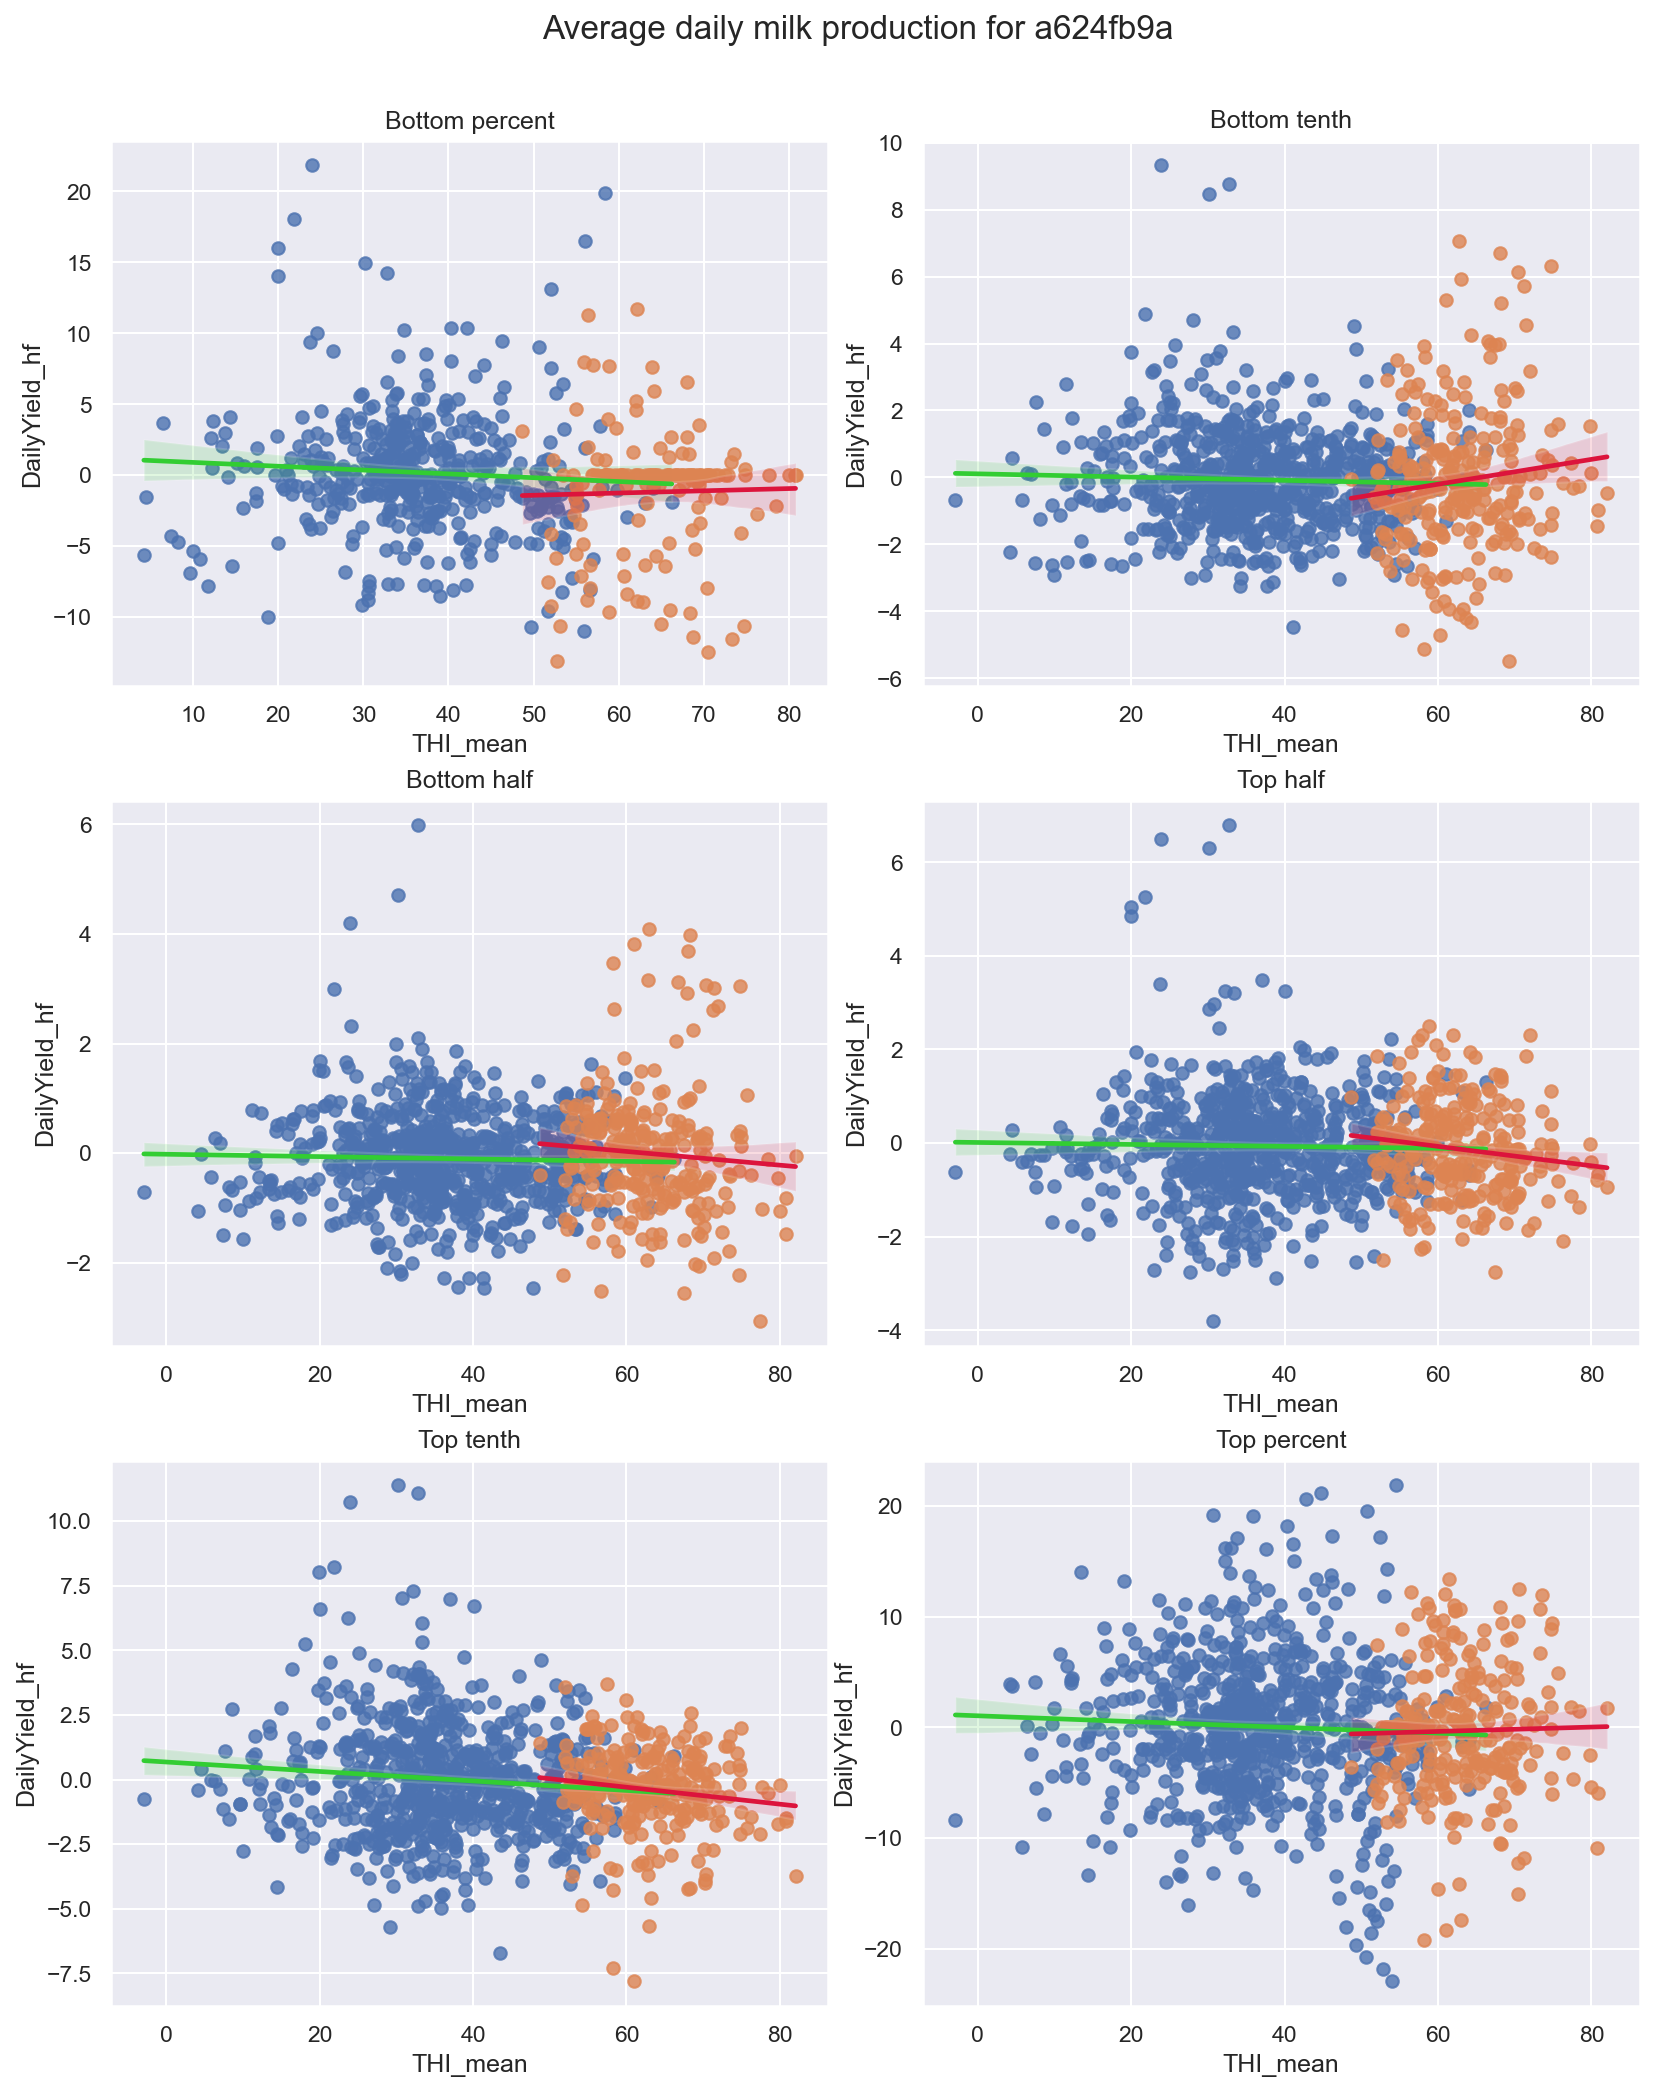


 f454e660 

The correlations between average daily yield and THI_mean for the bottom percent of producers are:
Pearson: -0.029 		 Kendall: 0.011 		 Spearman: 0.018

The correlations between average daily yield and THI_mean for the bottom percent of producers in summer are:
Pearson: -0.081 		 Kendall: 0.022 		 Spearman: -0.014

The correlations between average daily yield and THI_mean for the bottom tenth of producers are:
Pearson: 0.063 		 Kendall: 0.046 		 Spearman: 0.07

The correlations between average daily yield and THI_mean for the bottom tenth of producers in summer are:
Pearson: -0.225 		 Kendall: -0.136 		 Spearman: -0.197

The correlations between average daily yield and THI_mean for the bottom half of producers are:
Pearson: 0.086 		 Kendall: 0.079 		 Spearman: 0.121

The correlations between average daily yield and THI_mean for the bottom half of producers in summer are:
Pearson: -0.068 		 Kendall: -0.05 		 Spearman: -0.069

The correlations between average daily yield and

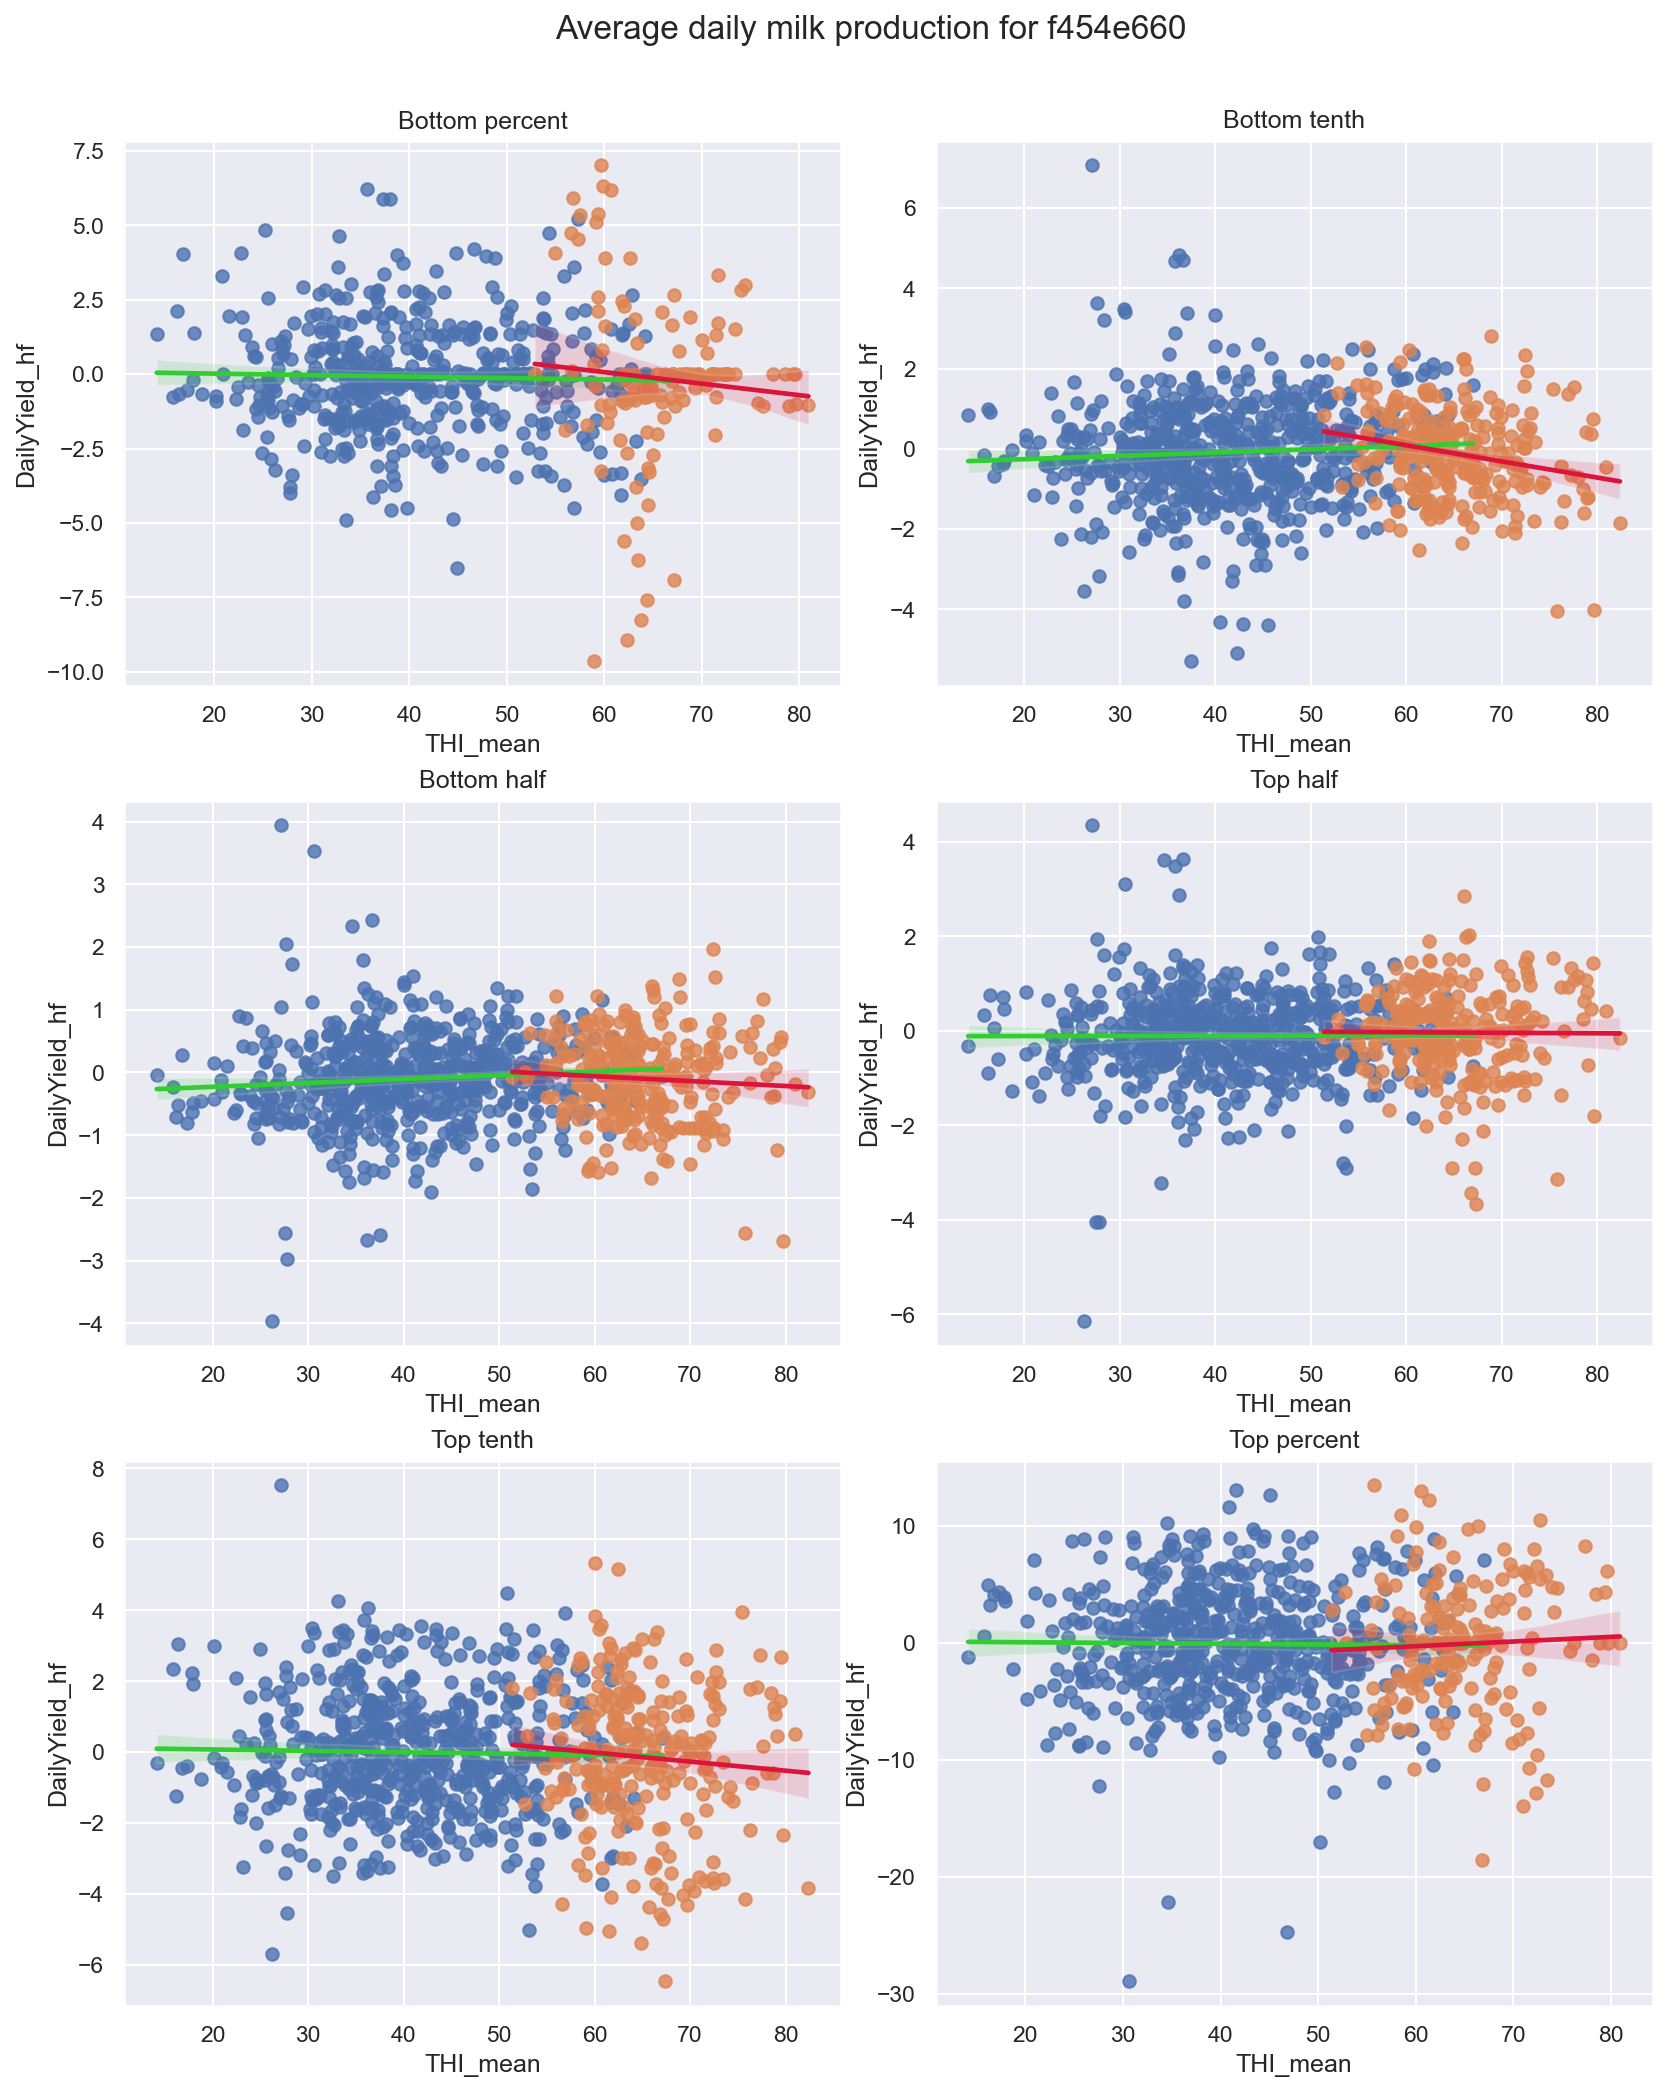


 540275a1 

The correlations between average daily yield and THI_mean for the bottom percent of producers are:
Pearson: 0.004 		 Kendall: 0.037 		 Spearman: 0.055

The correlations between average daily yield and THI_mean for the bottom percent of producers in summer are:
Pearson: 0.215 		 Kendall: 0.152 		 Spearman: 0.212

The correlations between average daily yield and THI_mean for the bottom tenth of producers are:
Pearson: -0.042 		 Kendall: -0.032 		 Spearman: -0.051

The correlations between average daily yield and THI_mean for the bottom tenth of producers in summer are:
Pearson: -0.053 		 Kendall: -0.051 		 Spearman: -0.073

The correlations between average daily yield and THI_mean for the bottom half of producers are:
Pearson: -0.045 		 Kendall: 0.002 		 Spearman: 0.001

The correlations between average daily yield and THI_mean for the bottom half of producers in summer are:
Pearson: 0.031 		 Kendall: -0.038 		 Spearman: -0.058

The correlations between average daily yield a

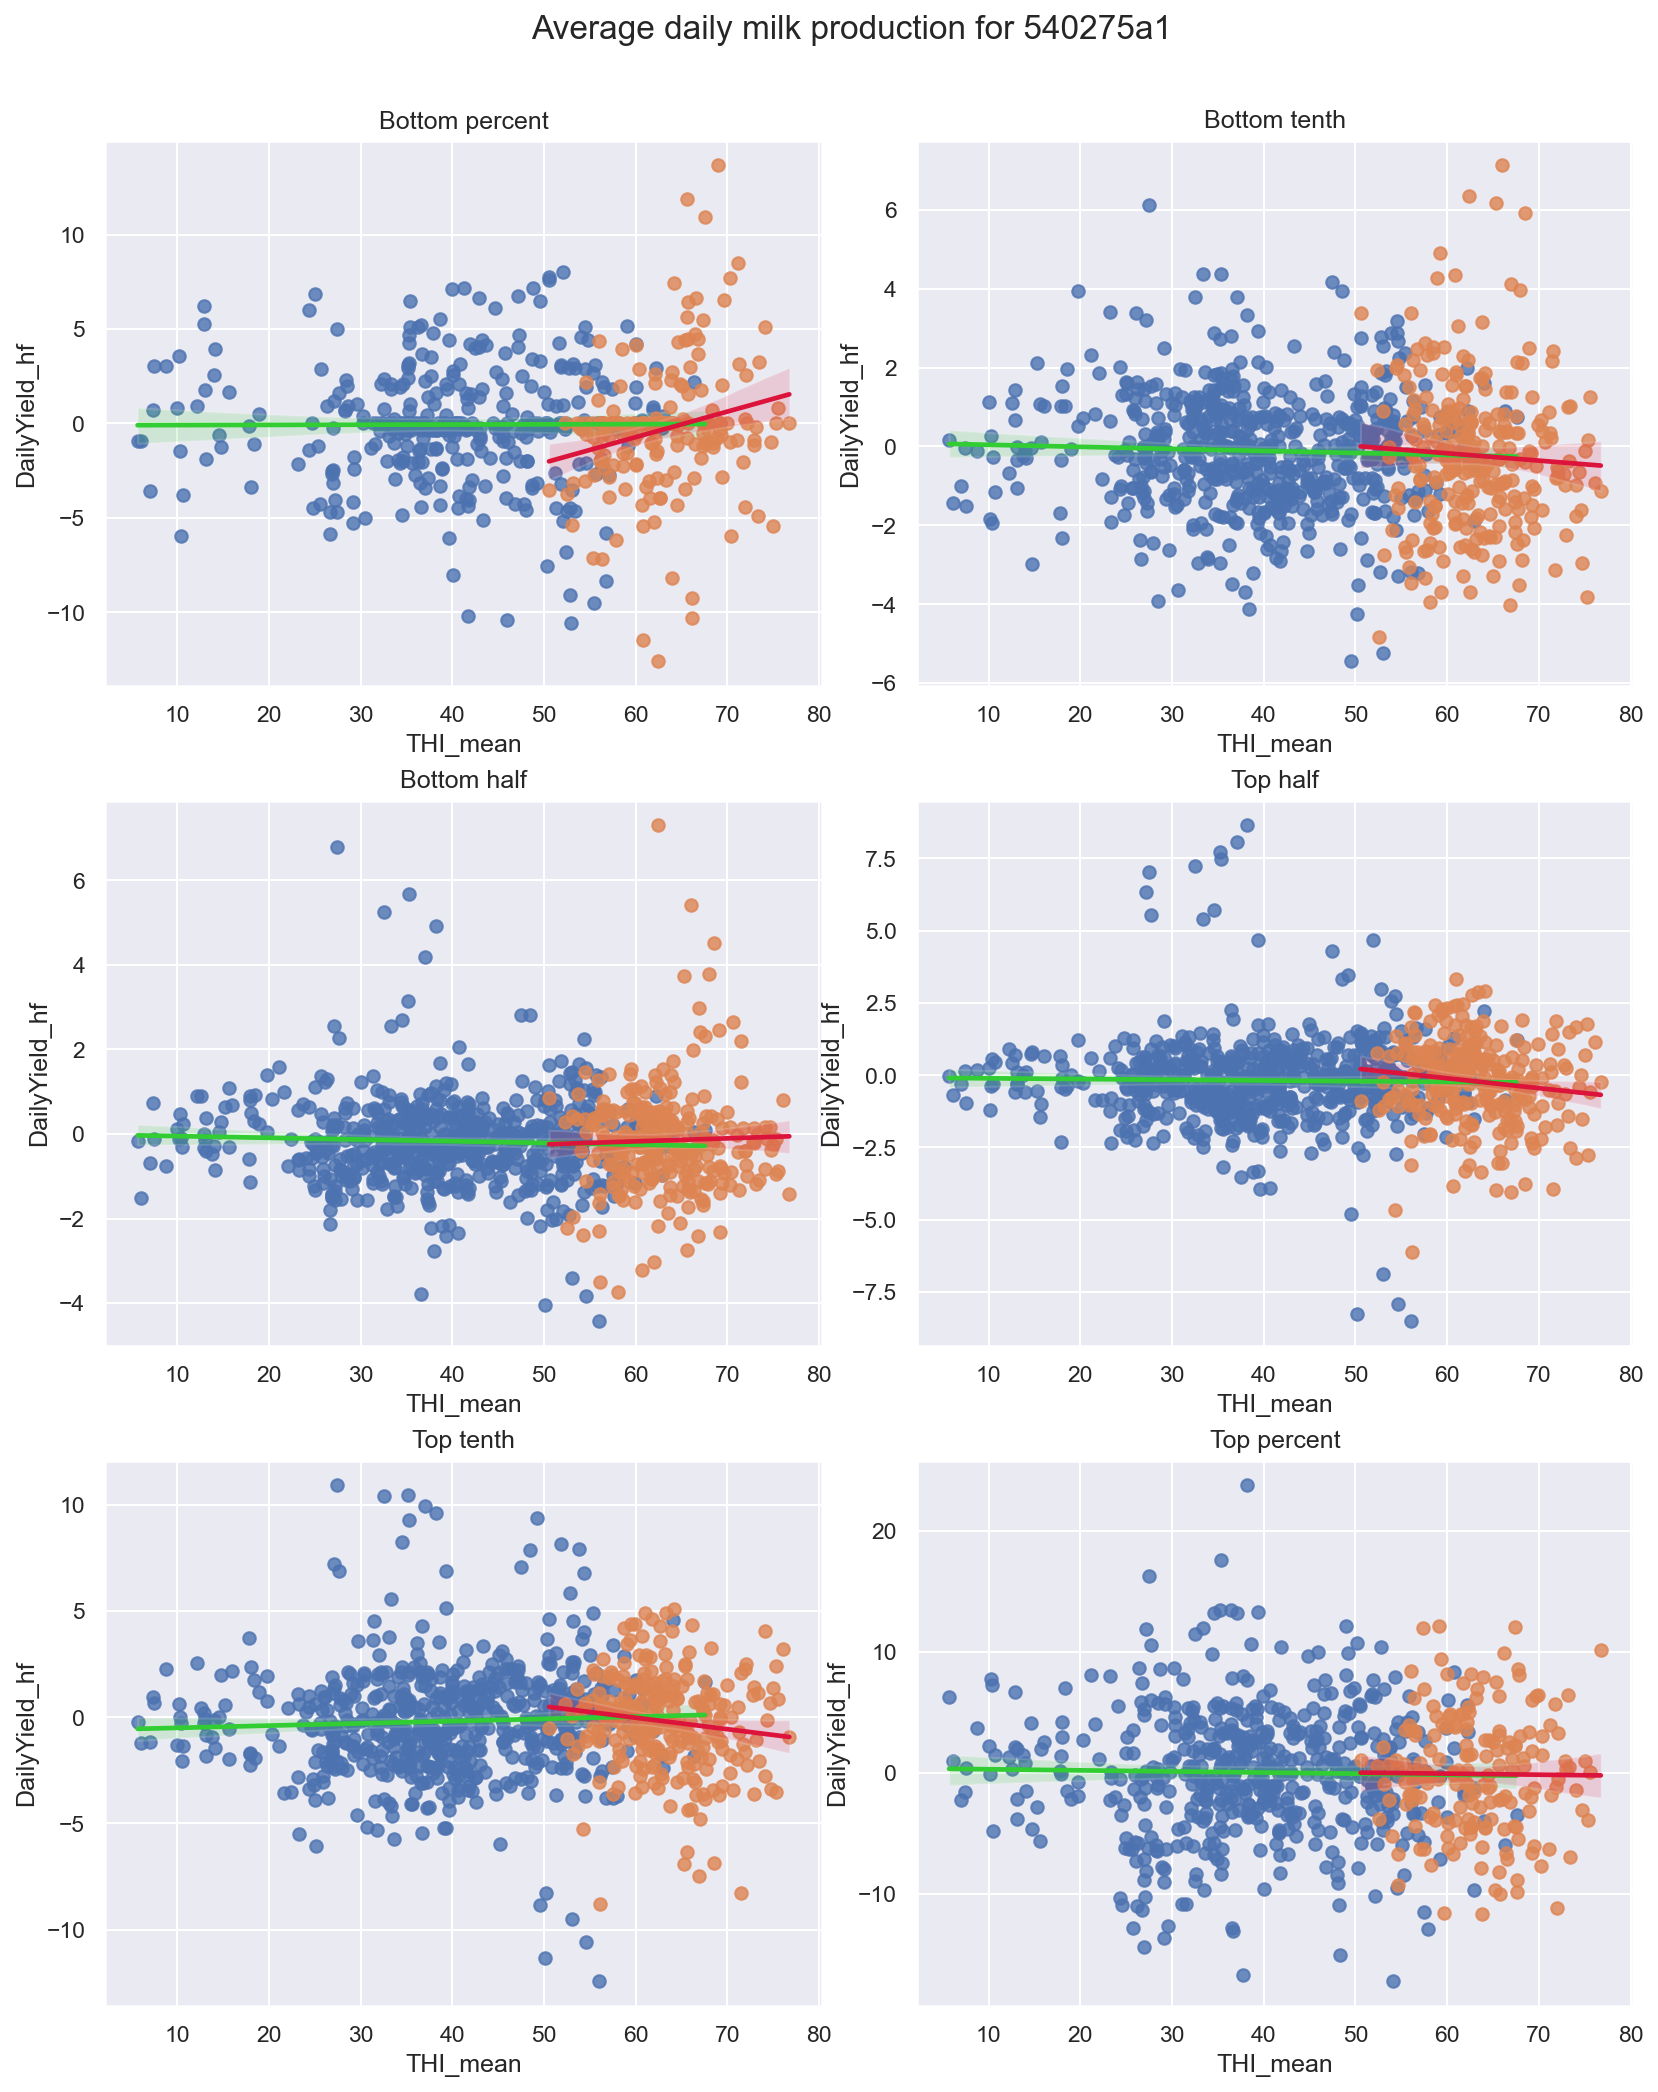


 ab18b151 

The correlations between average daily yield and THI_mean for the bottom percent of producers are:
Pearson: -0.013 		 Kendall: -0.007 		 Spearman: -0.015

The correlations between average daily yield and THI_mean for the bottom percent of producers in summer are:
Pearson: -0.211 		 Kendall: -0.116 		 Spearman: -0.181

The correlations between average daily yield and THI_mean for the bottom tenth of producers are:
Pearson: -0.064 		 Kendall: -0.036 		 Spearman: -0.054

The correlations between average daily yield and THI_mean for the bottom tenth of producers in summer are:
Pearson: -0.066 		 Kendall: -0.072 		 Spearman: -0.107

The correlations between average daily yield and THI_mean for the bottom half of producers are:
Pearson: -0.057 		 Kendall: -0.013 		 Spearman: -0.022

The correlations between average daily yield and THI_mean for the bottom half of producers in summer are:
Pearson: 0.003 		 Kendall: -0.058 		 Spearman: -0.088

The correlations between average daily

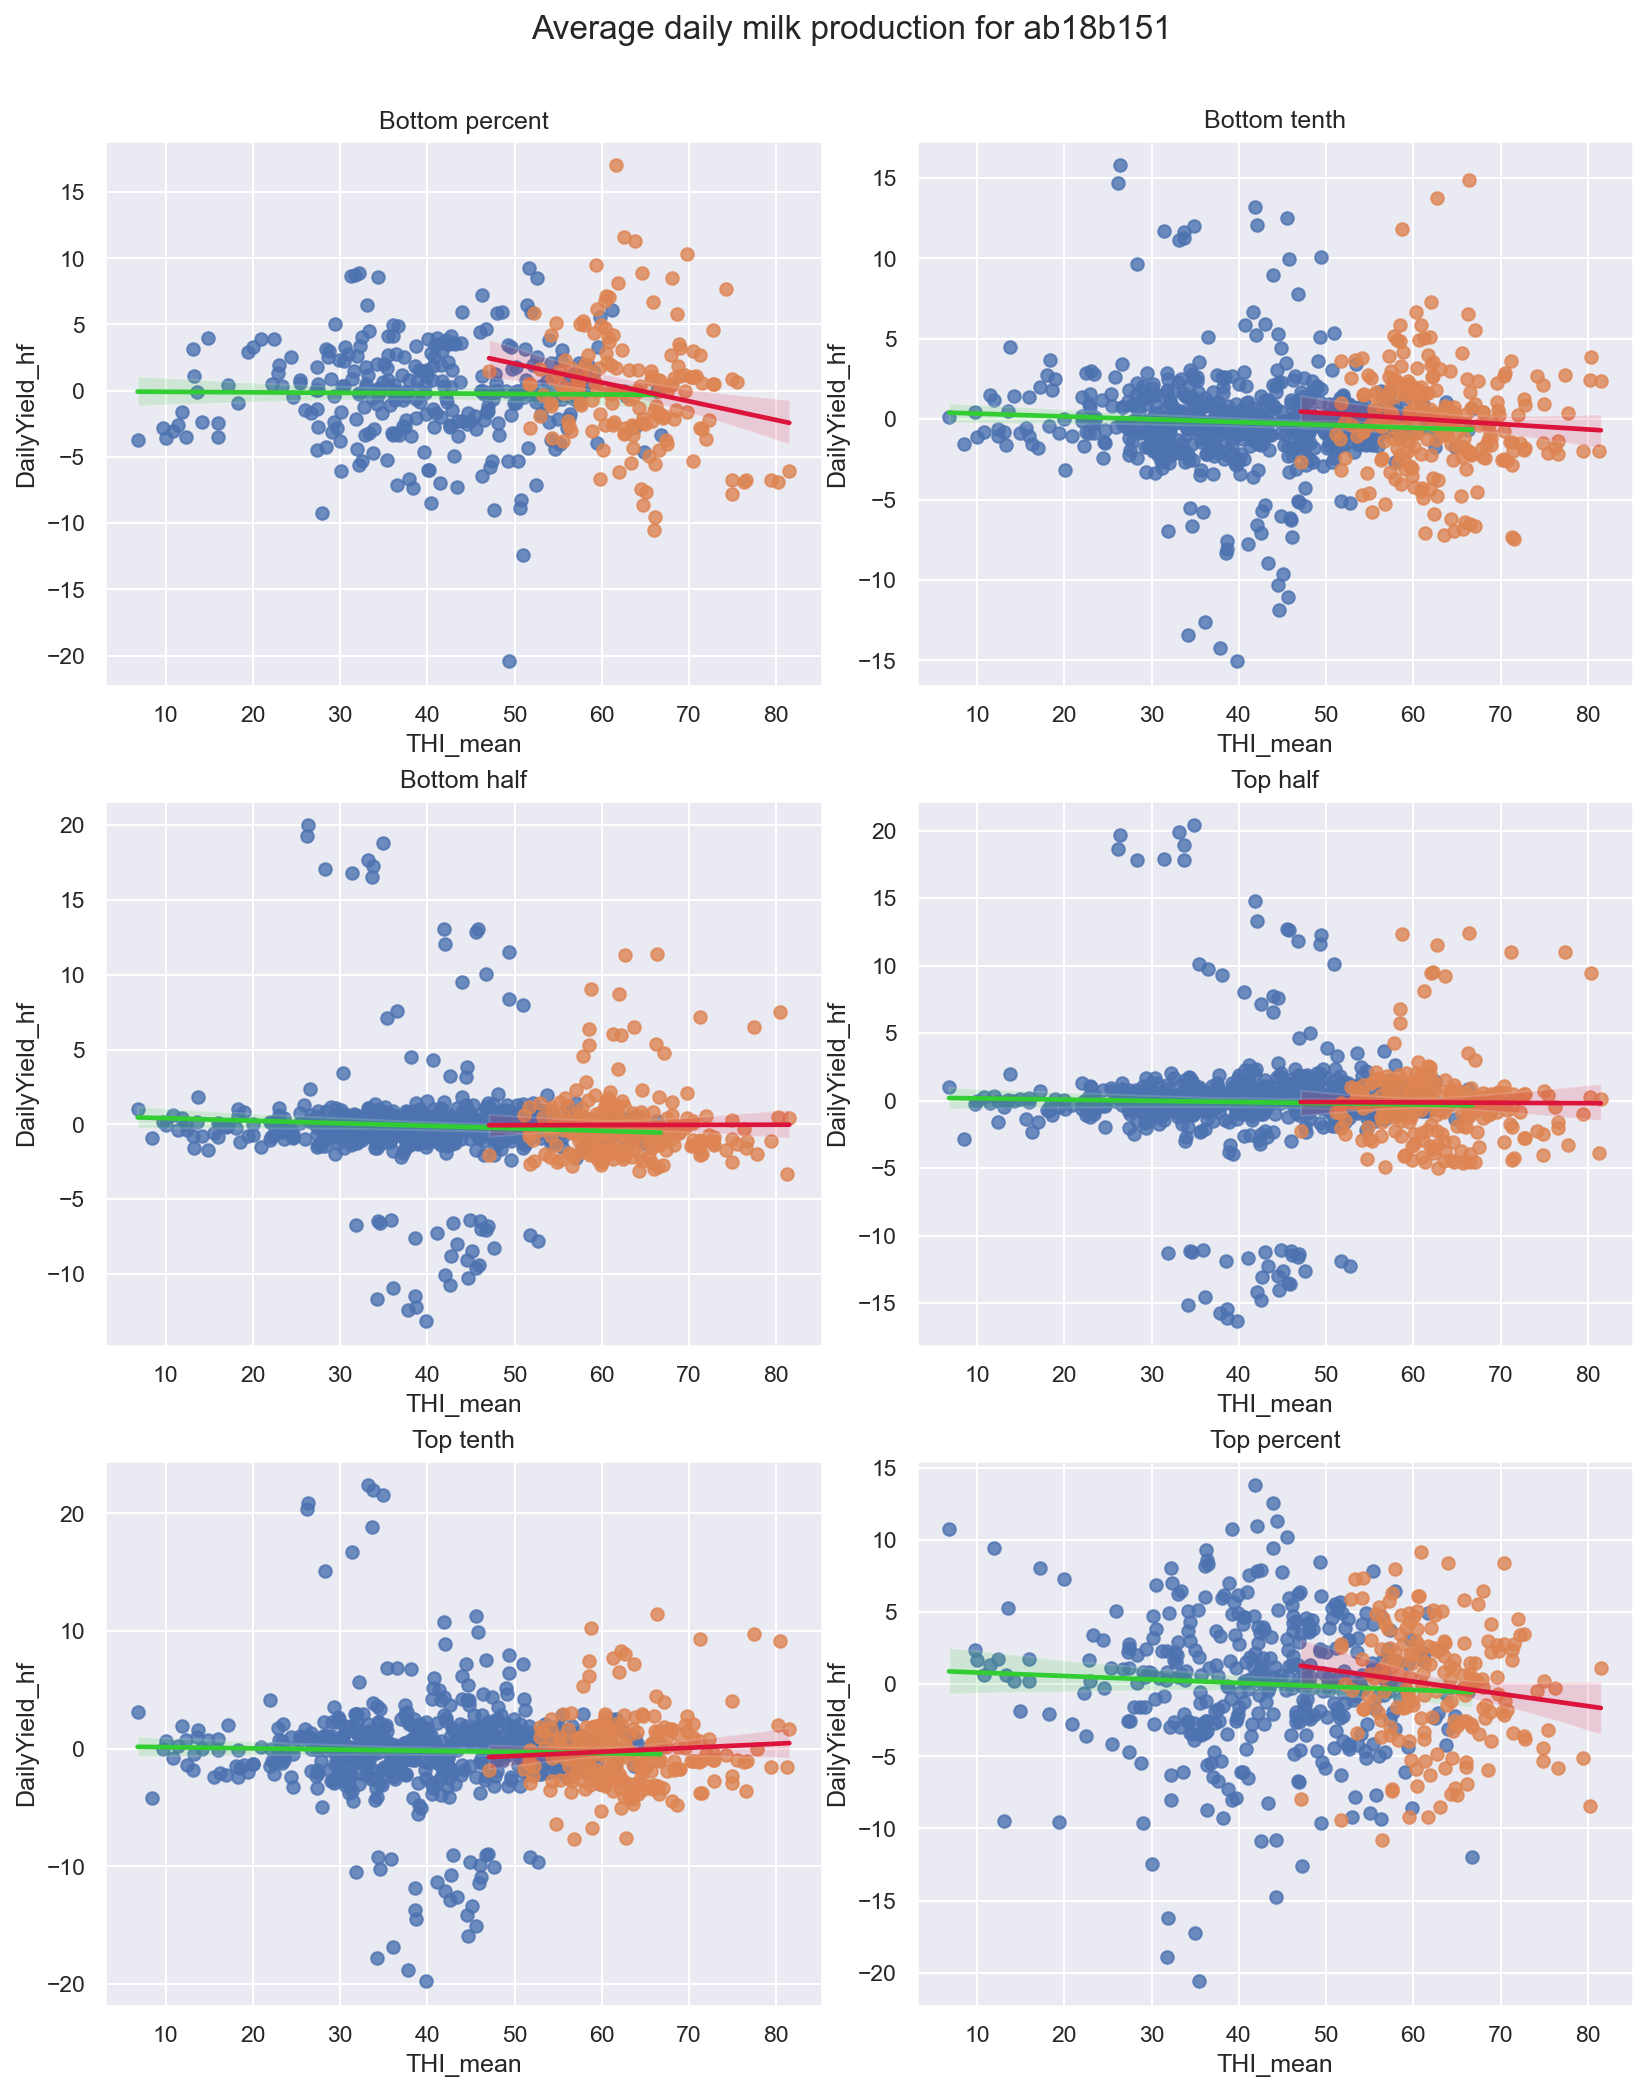


 752efd72 

The correlations between average daily yield and THI_mean for the bottom percent of producers are:
Pearson: 0.105 		 Kendall: 0.061 		 Spearman: 0.095

The correlations between average daily yield and THI_mean for the bottom percent of producers in summer are:
Pearson: -0.063 		 Kendall: -0.05 		 Spearman: -0.084

The correlations between average daily yield and THI_mean for the bottom tenth of producers are:
Pearson: 0.02 		 Kendall: -0.015 		 Spearman: -0.029

The correlations between average daily yield and THI_mean for the bottom tenth of producers in summer are:
Pearson: -0.016 		 Kendall: 0.014 		 Spearman: 0.021

The correlations between average daily yield and THI_mean for the bottom half of producers are:
Pearson: -0.043 		 Kendall: -0.124 		 Spearman: -0.182

The correlations between average daily yield and THI_mean for the bottom half of producers in summer are:
Pearson: -0.225 		 Kendall: -0.069 		 Spearman: -0.112

The correlations between average daily yield 

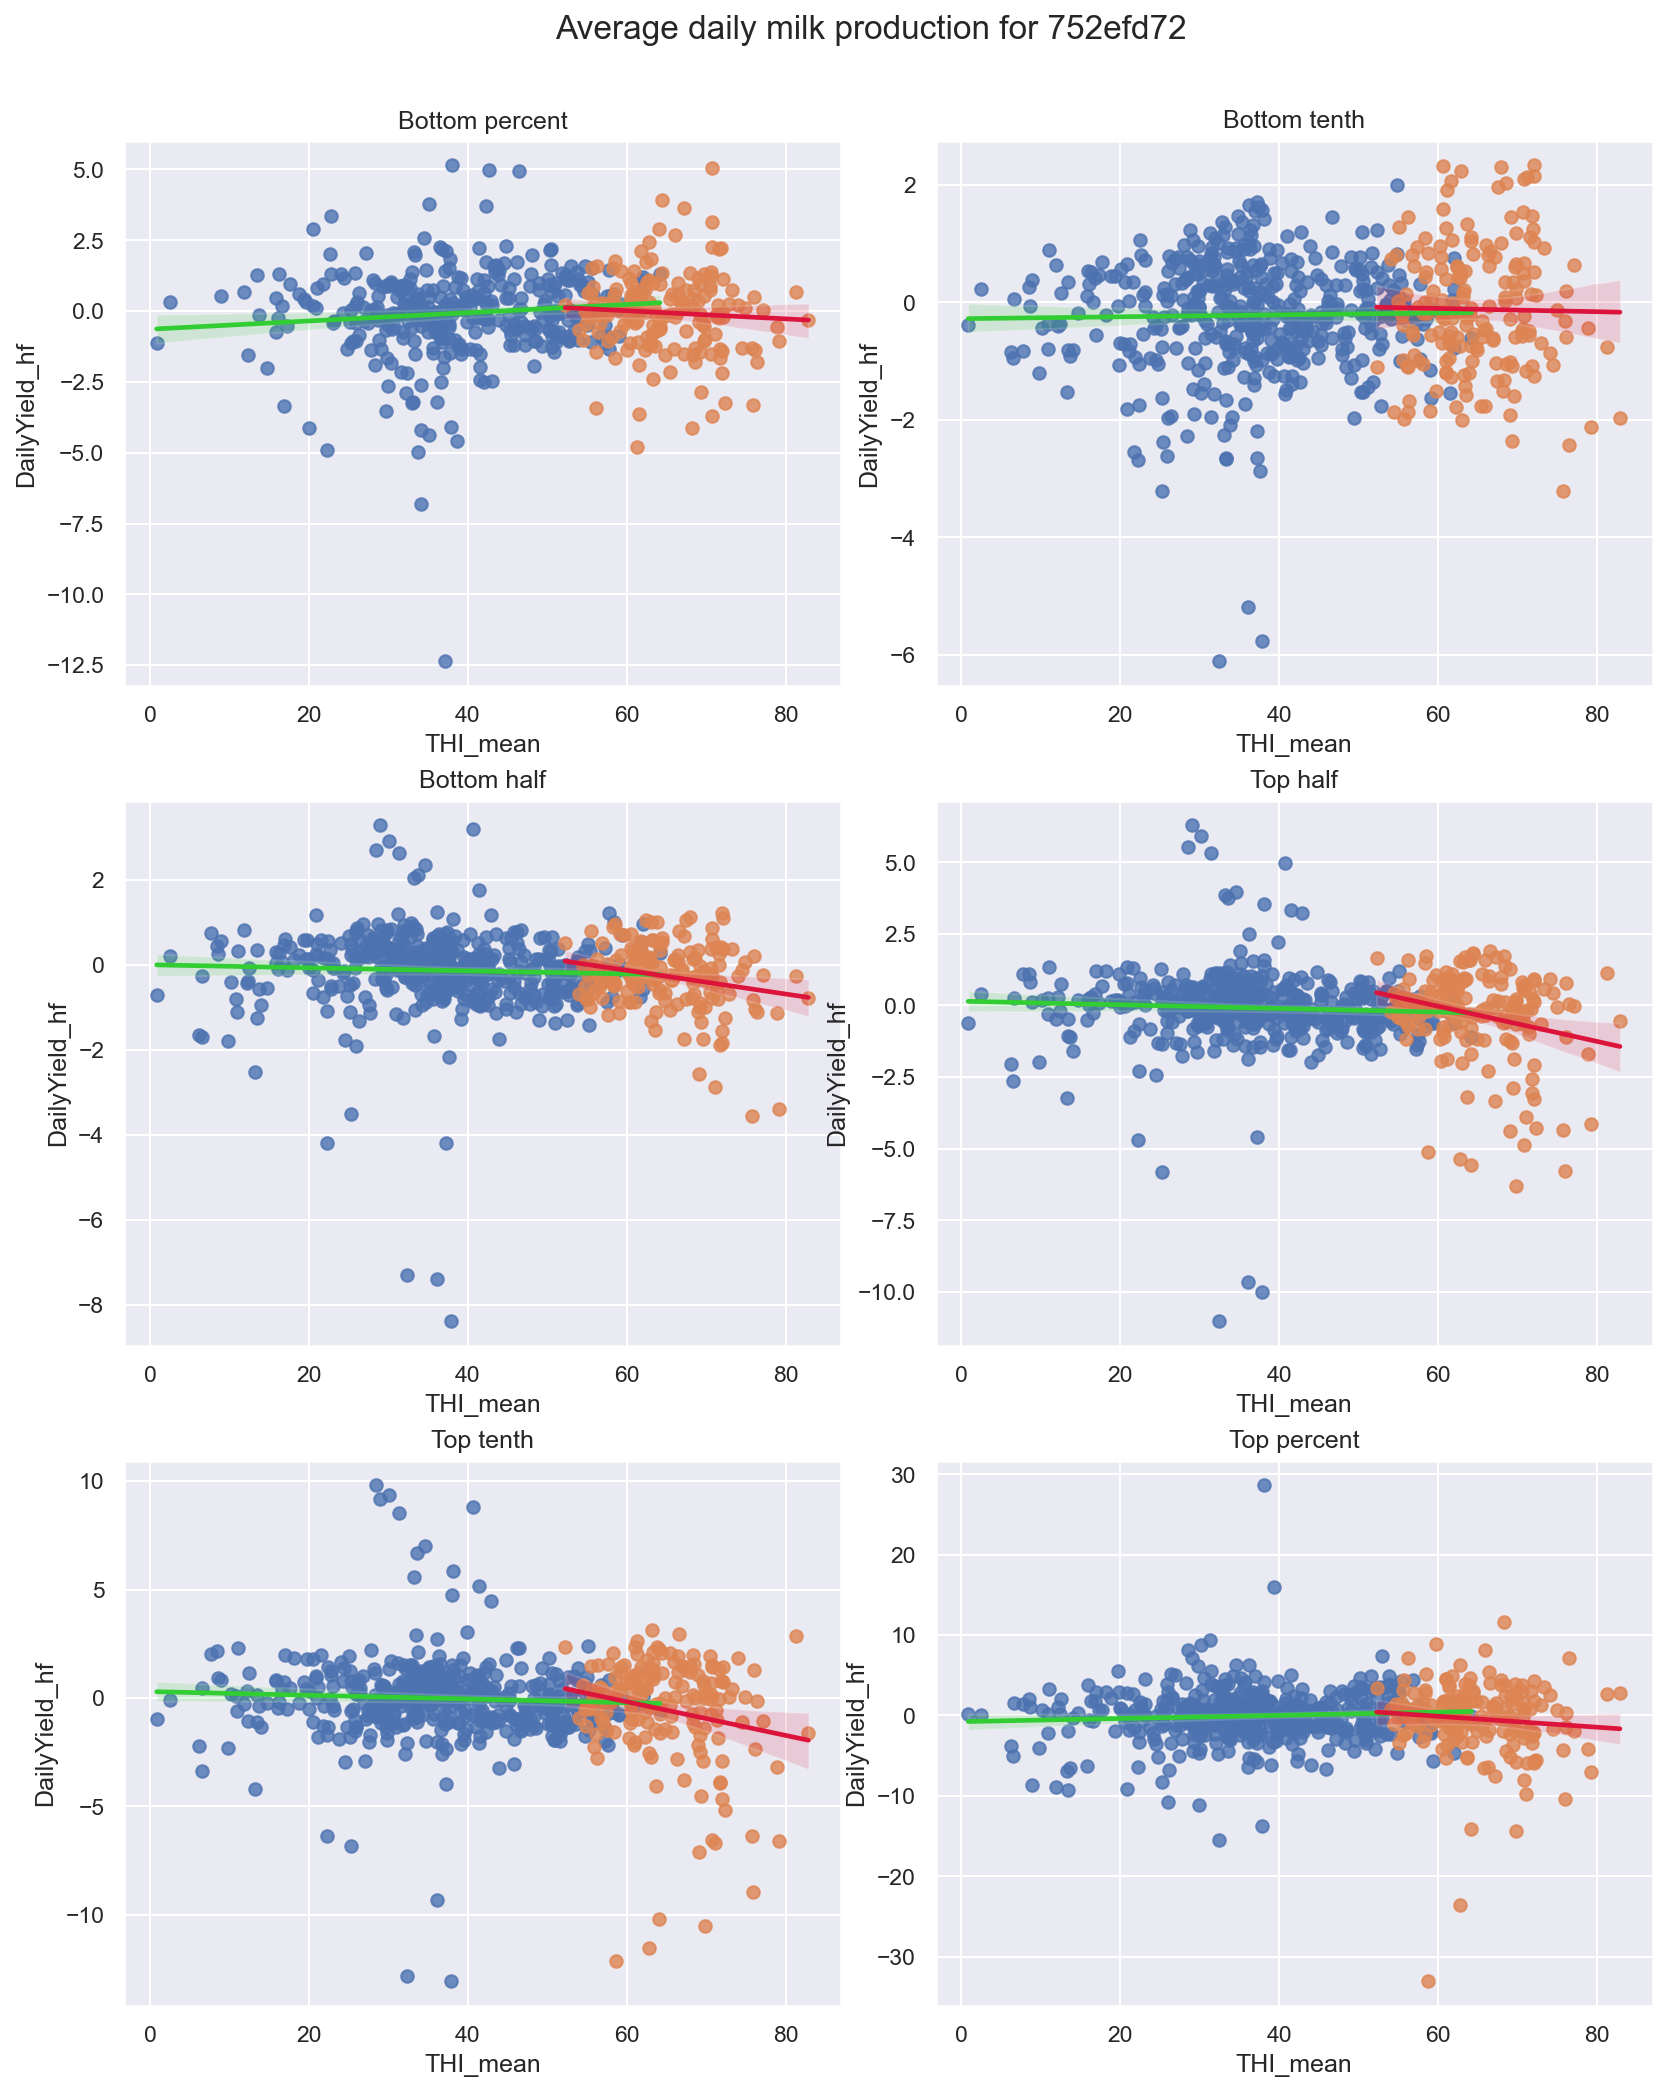


 5c06d92d 

The correlations between average daily yield and THI_mean for the bottom percent of producers are:
Pearson: 0.008 		 Kendall: -0.014 		 Spearman: -0.016

The correlations between average daily yield and THI_mean for the bottom percent of producers in summer are:
Pearson: 0.102 		 Kendall: 0.091 		 Spearman: 0.141

The correlations between average daily yield and THI_mean for the bottom tenth of producers are:
Pearson: -0.018 		 Kendall: 0.007 		 Spearman: 0.013

The correlations between average daily yield and THI_mean for the bottom tenth of producers in summer are:
Pearson: 0.016 		 Kendall: 0.036 		 Spearman: 0.068

The correlations between average daily yield and THI_mean for the bottom half of producers are:
Pearson: 0.02 		 Kendall: 0.045 		 Spearman: 0.065

The correlations between average daily yield and THI_mean for the bottom half of producers in summer are:
Pearson: 0.104 		 Kendall: 0.085 		 Spearman: 0.146

The correlations between average daily yield and THI_

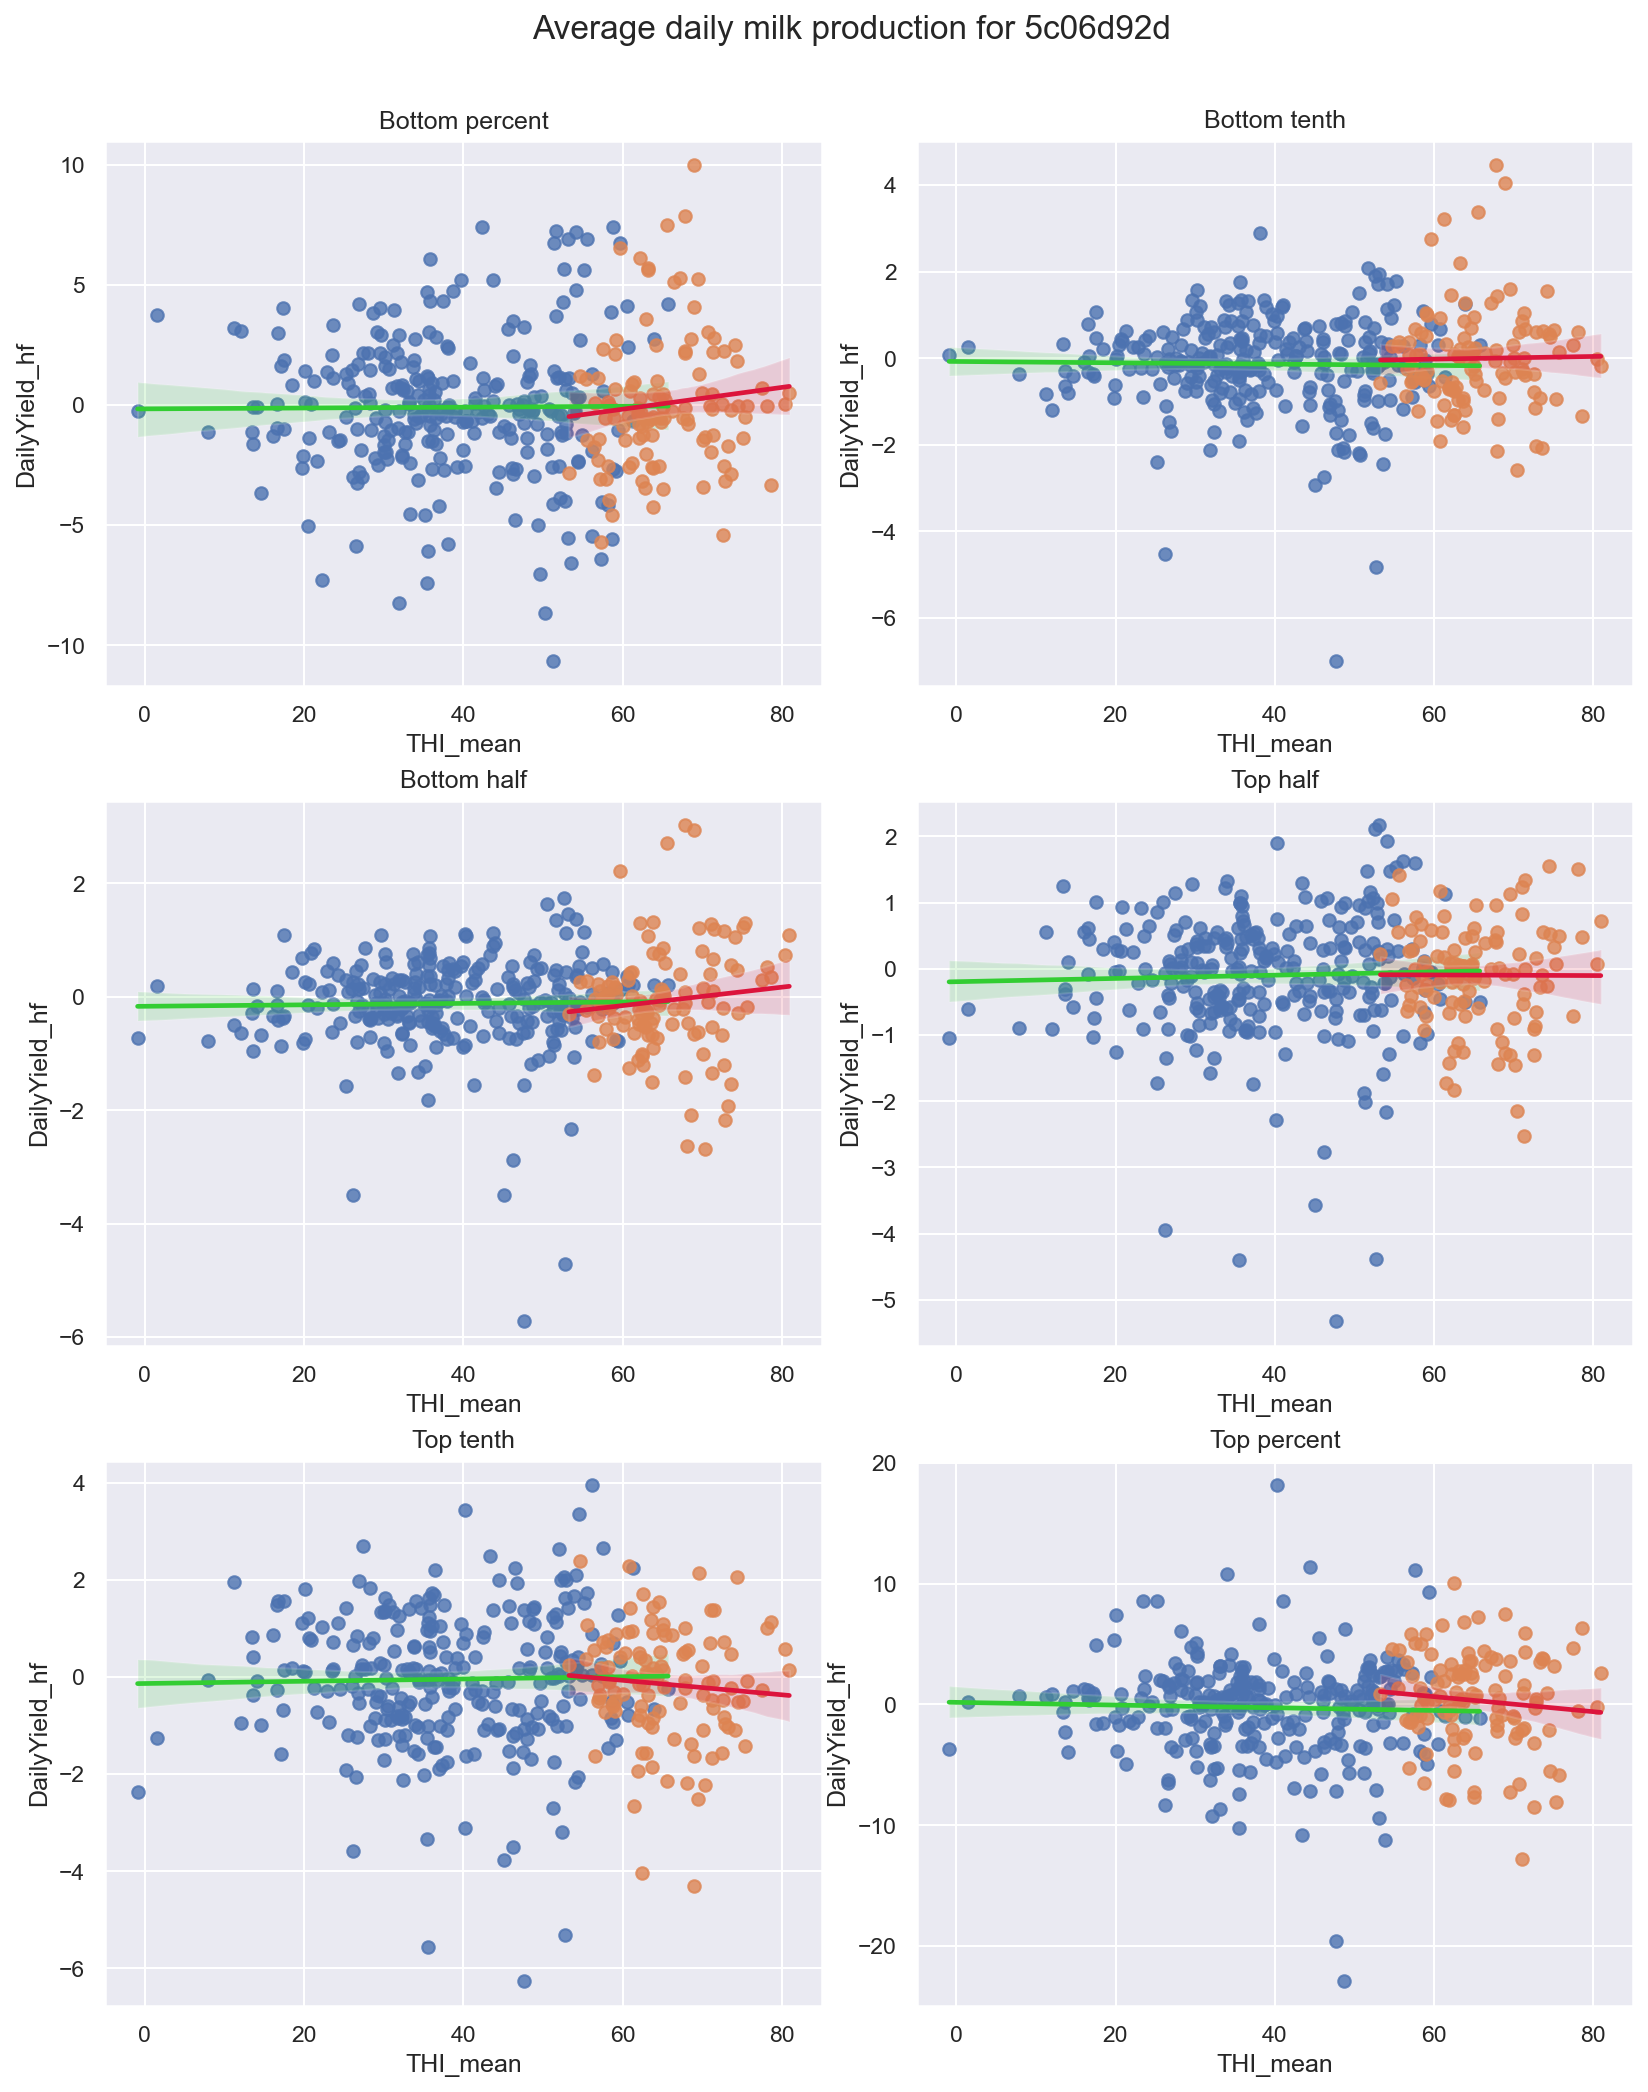


 ad0a39f5 

The correlations between average daily yield and THI_mean for the bottom percent of producers are:
Pearson: -0.045 		 Kendall: 0.01 		 Spearman: 0.01

The correlations between average daily yield and THI_mean for the bottom percent of producers in summer are:
Pearson: 0.02 		 Kendall: -0.042 		 Spearman: -0.057

The correlations between average daily yield and THI_mean for the bottom tenth of producers are:
Pearson: 0.079 		 Kendall: 0.056 		 Spearman: 0.082

The correlations between average daily yield and THI_mean for the bottom tenth of producers in summer are:
Pearson: 0.02 		 Kendall: -0.015 		 Spearman: -0.02

The correlations between average daily yield and THI_mean for the bottom half of producers are:
Pearson: 0.045 		 Kendall: 0.033 		 Spearman: 0.046

The correlations between average daily yield and THI_mean for the bottom half of producers in summer are:
Pearson: 0.062 		 Kendall: 0.057 		 Spearman: 0.08

The correlations between average daily yield and THI_mea

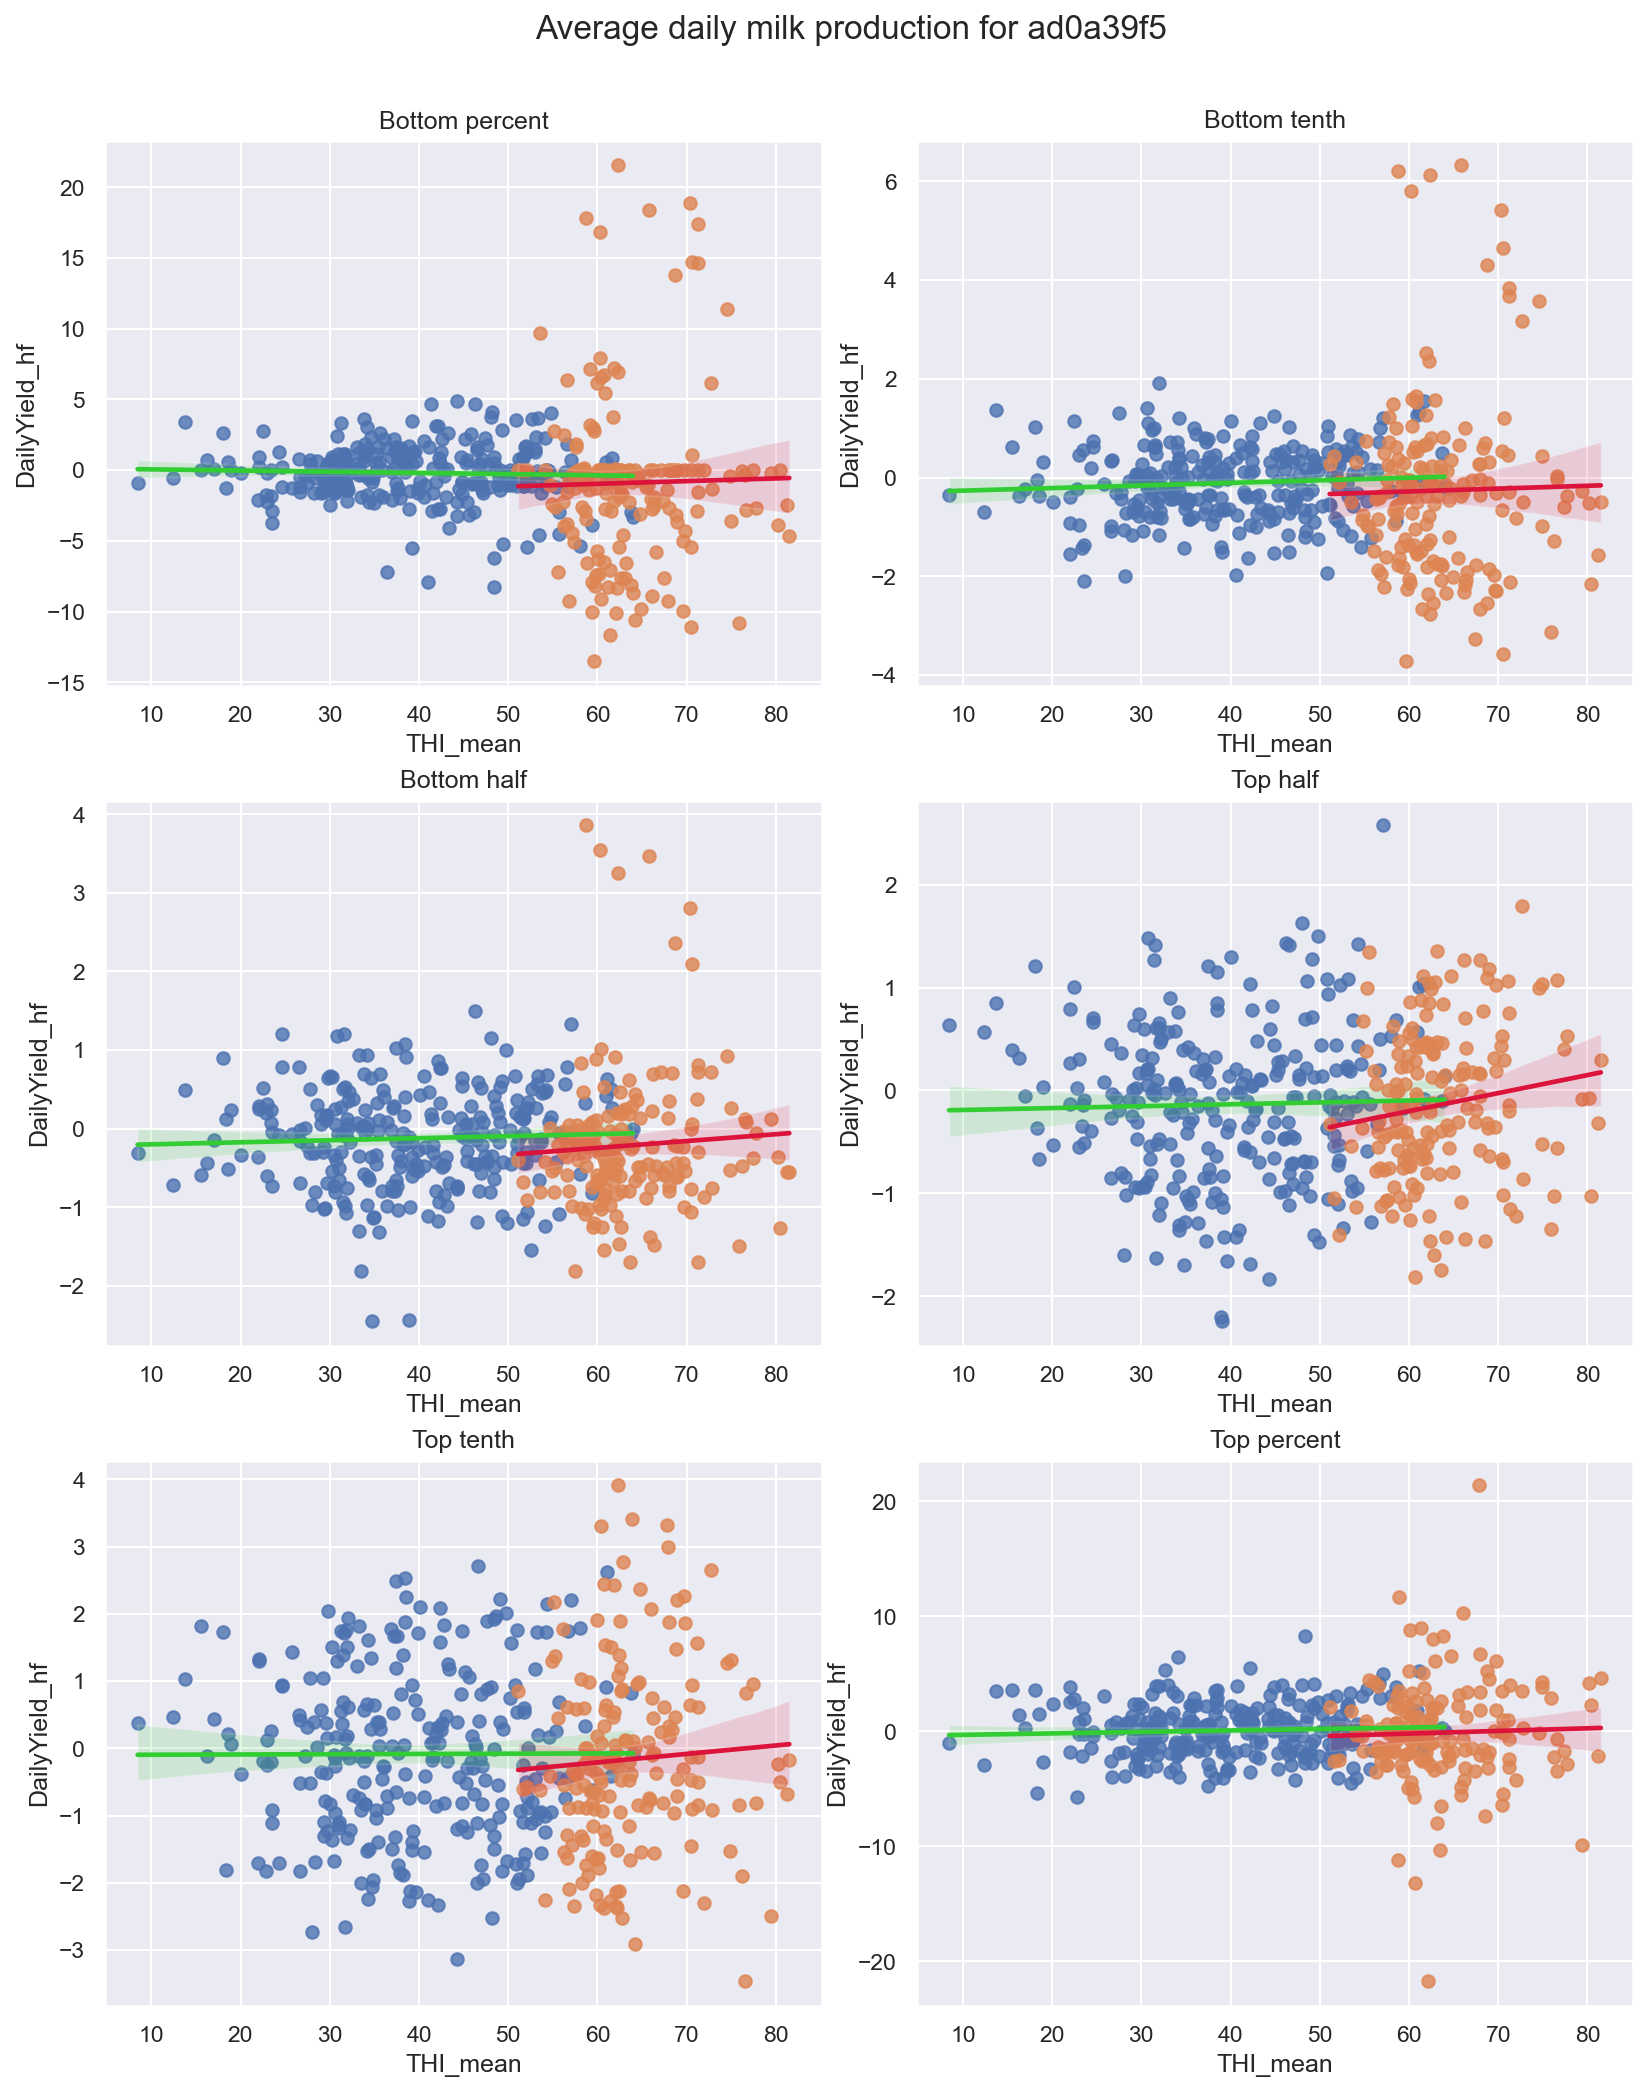

In [21]:
farms = ["a624fb9a","f454e660", "540275a1", "ab18b151", "752efd72", "5c06d92d", "ad0a39f5"]
for name in farms:
    farm = filtered[filtered["FarmName_Pseudo"] == name]
    print(f"\n {name} \n")
    averageFilteredCorrs(farm, "THI_mean", 1, name)

In [31]:
def filteredCorrs(farmSlice, wVar, o, fname):
    cownames = farmSlice["SE_Number"].unique()
    l = len(cownames)
    avProd = pd.DataFrame()
    for name in cownames:
        cow = farmSlice[farmSlice["SE_Number"] == name]
        avg = cow["DailyYield"].mean()
        avProd = pd.concat([avProd, pd.DataFrame.from_records([{"SE_Number": name, "AvgYield": avg}])])
    avProd = avProd.sort_values("AvgYield")

    bottomHalfNames = avProd.head(int(l/2))["SE_Number"]
    topHalfNames = avProd.tail(int(l/2))["SE_Number"]
    bottomTenthNames = avProd.head(int(l/10))["SE_Number"]
    topTenthNames = avProd.tail(int(l/10))["SE_Number"]
    bottomPercentNames = avProd.head(int(l/100))["SE_Number"]
    topPercentNames = avProd.tail(int(l/100))["SE_Number"]

    bottomHalf = farmSlice[farmSlice["SE_Number"].isin(bottomHalfNames)]
    topHalf = farmSlice[farmSlice["SE_Number"].isin(topHalfNames)]
    bottomTenth = farmSlice[farmSlice["SE_Number"].isin(bottomTenthNames)]
    topTenth = farmSlice[farmSlice["SE_Number"].isin(topTenthNames)]
    bottomPercent = farmSlice[farmSlice["SE_Number"].isin(bottomPercentNames)]
    topPercent = farmSlice[farmSlice["SE_Number"].isin(topPercentNames)]

    summerBottomPercent = bottomPercent[bottomPercent.index.month.isin([6,7,8])]
    winterBottomPercent = bottomPercent[bottomPercent.index.month.isin([1,2,3,4,5,9,10,11,12])]

    summerBottomTenth = bottomTenth [bottomTenth .index.month.isin([6,7,8])]
    winterBottomTenth  = bottomTenth [bottomTenth .index.month.isin([1,2,3,4,5,9,10,11,12])]

    summerBottomHalf = bottomHalf[bottomHalf.index.month.isin([6,7,8])]
    winterBottomHalf = bottomHalf[bottomHalf.index.month.isin([1,2,3,4,5,9,10,11,12])]

    summerTopHalf = topHalf[topHalf.index.month.isin([6,7,8])]
    winterTopHalf = topHalf[topHalf.index.month.isin([1,2,3,4,5,9,10,11,12])]

    summerTopTenth = topTenth[topTenth.index.month.isin([6,7,8])]
    winterTopTenth = topTenth[topTenth.index.month.isin([1,2,3,4,5,9,10,11,12])]

    summerTopPercent = topPercent[topPercent.index.month.isin([6,7,8])]
    winterTopPercent = topPercent[topPercent.index.month.isin([1,2,3,4,5,9,10,11,12])]

    corrHfPrint(winterBottomPercent, wVar, "bottom percent of producers")
    corrHfPrint(summerBottomPercent, wVar, "bottom percent of producers in summer")

    corrHfPrint(winterBottomTenth, wVar, "bottom tenth of producers")
    corrHfPrint(summerBottomTenth, wVar, "bottom tenth of producers in summer")

    corrHfPrint(winterBottomHalf, wVar, "bottom half of producers")
    corrHfPrint(summerBottomHalf, wVar, "bottom half of producers in summer")

    corrHfPrint(winterTopHalf, wVar, "top half of producers")
    corrHfPrint(summerTopHalf, wVar, "top half of producers in summer")

    corrHfPrint(winterTopTenth, wVar, "top tenth of producers")
    corrHfPrint(summerTopTenth, wVar, "top tenth of producers in summer")

    corrHfPrint(winterTopPercent, wVar, "top percent of producers")
    corrHfPrint(summerTopPercent, wVar, "top percent of producers in summer")

    sns.set()
    fig, axs = plt.subplots(3, 2, figsize = (11,14))
    fig.tight_layout(h_pad  = 3)
    axs = axs.ravel()
    sns.regplot(x = winterBottomPercent[wVar], y = winterBottomPercent["DailyYield_hf"], ax=axs[0], line_kws={"color": "limegreen"}, order = o).set(title='Bottom percent')
    sns.regplot(x = summerBottomPercent[wVar], y = summerBottomPercent["DailyYield_hf"], ax=axs[0], line_kws={"color": "crimson"}, order = o)
    sns.kdeplot(x = winterBottomPercent[wVar], y = winterBottomPercent["DailyYield_hf"], ax=axs[0])
    sns.kdeplot(x = summerBottomPercent[wVar], y = summerBottomPercent["DailyYield_hf"], ax=axs[0])

    sns.regplot(x = winterBottomTenth[wVar], y = winterBottomTenth["DailyYield_hf"], ax=axs[1], line_kws={"color": "limegreen"}, order = o).set(title='Bottom tenth')
    sns.regplot(x = summerBottomTenth[wVar], y = summerBottomTenth["DailyYield_hf"], ax=axs[1], line_kws={"color": "crimson"}, order = o)
    sns.kdeplot(x = winterBottomTenth[wVar], y = winterBottomTenth["DailyYield_hf"], ax=axs[1])
    sns.kdeplot(x = summerBottomTenth[wVar], y = summerBottomTenth["DailyYield_hf"], ax=axs[1])

    sns.regplot(x = winterBottomHalf[wVar], y = winterBottomHalf["DailyYield_hf"], ax=axs[2], line_kws={"color": "limegreen"}, order = o).set(title='Bottom half')
    sns.regplot(x = summerBottomHalf[wVar], y = summerBottomHalf["DailyYield_hf"], ax=axs[2], line_kws={"color": "crimson"}, order = o)
    sns.kdeplot(x = winterBottomHalf[wVar], y = winterBottomHalf["DailyYield_hf"], ax=axs[2])
    sns.kdeplot(x = summerBottomHalf[wVar], y = summerBottomHalf["DailyYield_hf"], ax=axs[2])

    sns.regplot(x = winterTopHalf[wVar], y = winterTopHalf["DailyYield_hf"], ax=axs[3], line_kws={"color": "limegreen"}, order = o).set(title='Top half')
    sns.regplot(x = summerTopHalf[wVar], y = summerTopHalf["DailyYield_hf"], ax=axs[3], line_kws={"color": "crimson"}, order = o)
    sns.kdeplot(x = winterTopHalf[wVar], y = winterTopHalf["DailyYield_hf"], ax=axs[3])
    sns.kdeplot(x = summerTopHalf[wVar], y = summerTopHalf["DailyYield_hf"], ax=axs[3])

    sns.regplot(x = winterTopTenth[wVar], y = winterTopTenth["DailyYield_hf"], ax=axs[4], line_kws={"color": "limegreen"}, order = o).set(title='Top tenth')
    sns.regplot(x = summerTopTenth[wVar], y = summerTopTenth["DailyYield_hf"], ax=axs[4], line_kws={"color": "crimson"}, order = o)
    sns.kdeplot(x = winterTopTenth[wVar], y = winterTopTenth["DailyYield_hf"], ax=axs[4])
    sns.kdeplot(x = summerTopTenth[wVar], y = summerTopTenth["DailyYield_hf"], ax=axs[4])

    sns.regplot(x = winterTopPercent[wVar], y = winterTopPercent["DailyYield_hf"], ax=axs[5], line_kws={"color": "limegreen"}, order = o).set(title='Top percent')
    sns.regplot(x = summerTopPercent[wVar], y = summerTopPercent["DailyYield_hf"], ax=axs[5], line_kws={"color": "crimson"}, order = o)
    sns.kdeplot(x = winterTopPercent[wVar], y = winterTopPercent["DailyYield_hf"], ax=axs[5])
    sns.kdeplot(x = summerTopPercent[wVar], y = summerTopPercent["DailyYield_hf"], ax=axs[5])

    fig.suptitle(f'Daily milk production for every cow in {fname}', fontsize=16)
    plt.subplots_adjust(top=0.92)

    plt.show()

In [33]:
farms = ["a624fb9a","f454e660", "540275a1", "ab18b151", "752efd72", "5c06d92d", "ad0a39f5"]
for name in farms:
    farm = filtered[filtered["FarmName_Pseudo"] == name]
    print(f"\n {name} \n")
    filteredCorrs(farm, "THI_mean", 1, name)


 a624fb9a 

                   SE_Number  DailyYield FarmName_Pseudo  r_sfc_mean  \
Timestamp                                                              
2020-06-01  SE-a624fb9a-1240       0.000        a624fb9a    0.519514   
2020-06-02  SE-a624fb9a-1240       0.000        a624fb9a    0.548575   
2020-06-03  SE-a624fb9a-1240       0.000        a624fb9a    0.508301   
2020-06-04  SE-a624fb9a-1240       0.000        a624fb9a    0.603546   
2020-06-05  SE-a624fb9a-1240       0.000        a624fb9a    0.666355   
...                      ...         ...             ...         ...   
2021-07-26  SE-a624fb9a-1240       0.000        a624fb9a    0.637611   
2021-07-27  SE-a624fb9a-1240       0.000        a624fb9a    0.725199   
2021-07-28  SE-a624fb9a-1240       3.930        a624fb9a    0.851613   
2021-07-29  SE-a624fb9a-1240       5.445        a624fb9a    0.871442   
2021-07-30  SE-a624fb9a-1240       6.960        a624fb9a    0.790848   

             T_C_mean   THI_mean  THI_adj_mean  Da